In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tf_explain.core.grad_cam import GradCAM
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [2]:
# Define the dataset directory
data_dir = r'C:\Users\Rohit Srivastava\OneDrive\Desktop\DL dataset\3\logos_v3_mini\logos3\train'

In [3]:
# Define class names based on subdirectories in the dataset directory
class_names = os.listdir(data_dir)

In [4]:
# Define image size
image_size = (224, 224)

In [5]:
# Data Preprocessing
images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)  # Adjust preprocessing function for ResNet
        images.append(img)
        labels.append(class_name)

X = np.array(images)
y = np.array(labels)

In [6]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Convert class names to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [8]:
# One-hot encode the labels
num_classes = len(class_names)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

In [9]:
# Load a pre-trained model (ResNet50 in this example)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
# Add custom classification layers on top of the base model
model = Sequential([
    GlobalAveragePooling2D(input_shape=(224, 224, 3)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [11]:
# Fine-tune the model (unfreeze more layers)
# Unfreeze more layers in the base_model (e.g., the last 10 layers)
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [12]:
# Experiment with different learning rates and optimizers
learning_rates = [0.001, 0.0001, 0.00001]
optimizers = ['adam', 'rmsprop']

for learning_rate in learning_rates:
    for optimizer_name in optimizers:
        print(f"Fine-tuning with learning rate {learning_rate} and optimizer {optimizer_name}")

        # Compile the model with the current learning rate and optimizer
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Continue fine-tuning the model using X_train, y_train_one_hot
        # Evaluate the fine-tuned model on X_val, y_val_one_hot
        epochs = 10  # We can adjust the number of epochs as needed
        batch_size = 32  # We can adjust the batch size as needed

        fine_tuned_history = model.fit(
            X_train, y_train_one_hot,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val_one_hot)
        )

        fine_tuned_evaluation = model.evaluate(X_val, y_val_one_hot)

        print("Fine-tuned Model Evaluation:")
        print("Loss:", fine_tuned_evaluation[0])
        print("Accuracy:", fine_tuned_evaluation[1])

Fine-tuning with learning rate 0.001 and optimizer adam
Epoch 1/10
44/44 [==============================] - 2s 29ms/step - loss: 1.8324 - accuracy: 0.4453 - val_loss: 1.4844 - val_accuracy: 0.4799
Epoch 2/10
44/44 [==============================] - 1s 19ms/step - loss: 1.3987 - accuracy: 0.4971 - val_loss: 1.5925 - val_accuracy: 0.5000
Epoch 3/10
44/44 [==============================] - 1s 19ms/step - loss: 1.3256 - accuracy: 0.5115 - val_loss: 1.3434 - val_accuracy: 0.5115
Epoch 4/10
44/44 [==============================] - 1s 20ms/step - loss: 1.2491 - accuracy: 0.5338 - val_loss: 1.4724 - val_accuracy: 0.4856
Epoch 5/10
44/44 [==============================] - 1s 20ms/step - loss: 1.2919 - accuracy: 0.5309 - val_loss: 1.3745 - val_accuracy: 0.4741
Epoch 6/10
44/44 [==============================] - 1s 24ms/step - loss: 1.2218 - accuracy: 0.5518 - val_loss: 1.3267 - val_accuracy: 0.5345
Epoch 7/10
44/44 [==============================] - 1s 27ms/step - loss: 1.2257 - accuracy: 0.5223

Epoch 1/10
44/44 [==============================] - 2s 25ms/step - loss: 0.9039 - accuracy: 0.6489 - val_loss: 1.1826 - val_accuracy: 0.5690
Epoch 2/10
44/44 [==============================] - 1s 17ms/step - loss: 0.9032 - accuracy: 0.6482 - val_loss: 1.1827 - val_accuracy: 0.5661
Epoch 3/10
44/44 [==============================] - 1s 18ms/step - loss: 0.9032 - accuracy: 0.6482 - val_loss: 1.1832 - val_accuracy: 0.5661
Epoch 4/10
44/44 [==============================] - 1s 18ms/step - loss: 0.9031 - accuracy: 0.6511 - val_loss: 1.1836 - val_accuracy: 0.5661
Epoch 5/10
44/44 [==============================] - 1s 17ms/step - loss: 0.9027 - accuracy: 0.6489 - val_loss: 1.1841 - val_accuracy: 0.5661
Epoch 6/10
44/44 [==============================] - 1s 17ms/step - loss: 0.9027 - accuracy: 0.6518 - val_loss: 1.1842 - val_accuracy: 0.5661
Epoch 7/10
44/44 [==============================] - 1s 19ms/step - loss: 0.9024 - accuracy: 0.6504 - val_loss: 1.1841 - val_accuracy: 0.5690
Epoch 8/10
44

In [13]:
# Print the layers and their output shapes in the ResNet50 model
for layer in base_model.layers:
    print(layer.name, layer.output_shape)

input_1 [(None, 224, 224, 3)]
conv1_pad (None, 230, 230, 3)
conv1_conv (None, 112, 112, 64)
conv1_bn (None, 112, 112, 64)
conv1_relu (None, 112, 112, 64)
pool1_pad (None, 114, 114, 64)
pool1_pool (None, 56, 56, 64)
conv2_block1_1_conv (None, 56, 56, 64)
conv2_block1_1_bn (None, 56, 56, 64)
conv2_block1_1_relu (None, 56, 56, 64)
conv2_block1_2_conv (None, 56, 56, 64)
conv2_block1_2_bn (None, 56, 56, 64)
conv2_block1_2_relu (None, 56, 56, 64)
conv2_block1_0_conv (None, 56, 56, 256)
conv2_block1_3_conv (None, 56, 56, 256)
conv2_block1_0_bn (None, 56, 56, 256)
conv2_block1_3_bn (None, 56, 56, 256)
conv2_block1_add (None, 56, 56, 256)
conv2_block1_out (None, 56, 56, 256)
conv2_block2_1_conv (None, 56, 56, 64)
conv2_block2_1_bn (None, 56, 56, 64)
conv2_block2_1_relu (None, 56, 56, 64)
conv2_block2_2_conv (None, 56, 56, 64)
conv2_block2_2_bn (None, 56, 56, 64)
conv2_block2_2_relu (None, 56, 56, 64)
conv2_block2_3_conv (None, 56, 56, 256)
conv2_block2_3_bn (None, 56, 56, 256)
conv2_block2_add 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 3)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              4096      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 531974 (2.03 MB)
Trainable params: 531974 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Rohit Srivastava\AppData\Local\Temp\ipykernel_10316\1948813996.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(133)


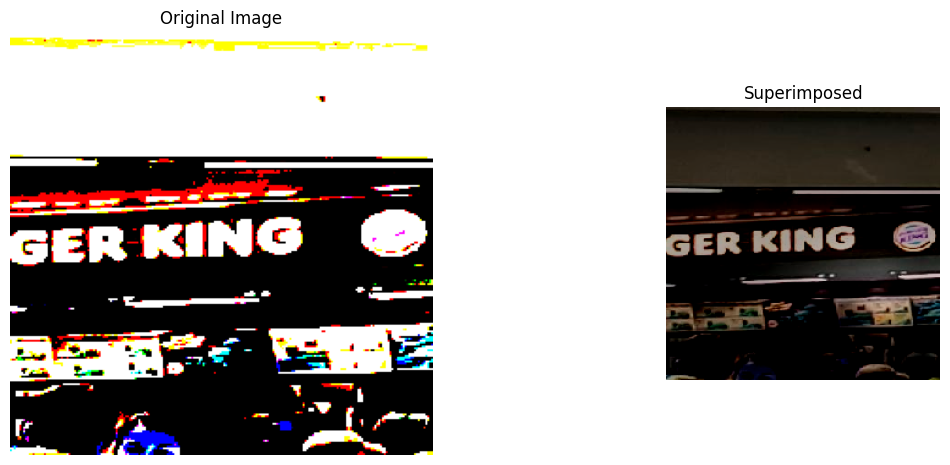

In [15]:
# Visualize feature maps using GradCAM
# Specify the name of the layer in ResNet50 for visualization
# Choose a valid layer name from the list above and set it as the target layer
target_layer = 'conv5_block3_out'  

# Load the ResNet50 model pre-trained on ImageNet data
model = ResNet50(weights='imagenet')

# Replace this with the actual path to your image
image_path = r'C:\Users\Rohit Srivastava\OneDrive\Desktop\DL dataset\3\logos_v3_mini\logos3\train\Burger King\ankamall_image_31.jpg'

img = image.load_img(image_path, target_size=(224, 224))  # ResNet50 input size
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

# Predict the class of the image
predictions = model.predict(img)
predicted_class = np.argmax(predictions)
predicted_class_name = decode_predictions(predictions, top=1)[0][0][1]

# Get the ResNet50 model's last convolutional layer
last_conv_layer = model.get_layer('conv5_block3_out')

# Create a model that maps the original input image to the activations of the last conv layer
heatmap_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Calculate the gradient of the predicted class with regard to the output feature map of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(img)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)

# Pool the gradients over each feature map to get the importance of the feature map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each feature map by "how important this feature map is" (pooled gradients)
heatmap = tf.matmul(conv_outputs, pooled_grads[..., tf.newaxis])

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)

# Convert the heatmap to RGB format
heatmap = tf.image.grayscale_to_rgb(heatmap)

# Resize the heatmap to the original image size
heatmap = tf.image.resize(heatmap, (img.shape[1], img.shape[2]))

# Convert the heatmap to a numpy array for visualization
heatmap = heatmap.numpy()

# Superimpose the heatmap on the original image
superimposed_img = (heatmap[0] * 0.4) + (img[0] / 255.0)

# Clip the values to be in the range [0, 1]
superimposed_img = np.clip(superimposed_img, 0, 1)

# Plot the original image and heatmap
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.squeeze(img, axis=0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(heatmap[0])
plt.title(f'GradCAM Heatmap for {predicted_class_name}')
plt.axis('off')

plt.subplot(133)
plt.title("Superimposed")
plt.imshow(superimposed_img)
plt.axis('off')

plt.show()